#KOR Bi-LSTM BASED
## 데이터 이해 및 전처리 과정
>1. 데이터 로드 및 필요한 라이브러리 호출
>2. 데이터 정제하기
>3. 토큰화
>4. 인코딩
>5. 패딩 작업
## BILSTM을 베이스로 한 모델 구축
>1. 베스트모델 학습
>2. 모델에 예시 적용 및 예측

**데이터 이해 및 전처리 과정**

In [1]:
DATA_TYPE = "anonym"
LANGUAGE = "ko"
#데이터 타입(언어어) 반영

1. 데이터 로드 및 필요한 라이브러리 호출

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 45.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
total_data = pd.read_csv("/content/dataset_10116_34477.csv")  #데이터 파일 불러오기

In [5]:
#total_data[:5] #상위데이터 확인

In [6]:
RANDOM_STATE = 42

2.데이터 정제하기

In [7]:
X = total_data
y = total_data['label']

# 토탈 데이터를 학습용과 테스트용으로 8:2 비율에 맞춰 나눕니다.
# Train : Test = 8 : 2
train_data, test_data, y_train, y_test=train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=RANDOM_STATE)

train_data = train_data.reset_index()
# valid_data = valid_data.reset_index()
test_data  = test_data.reset_index()

y_train = y_train.reset_index()['label']
# y_valid = y_valid.reset_index()['label']
y_test  = y_test.reset_index()['label']

print(f'--- Rate of Falls in Train Datasets (N = {len(y_train)}) ---')
print(f'Non-Fall Data (label : 0) = {y_train.value_counts()[0]} ({round(y_train.value_counts()[0]/len(y_train) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_train.value_counts()[1]} ({round(y_train.value_counts()[1]/len(y_train) * 100,3)})%')
print()
# print(f'--- Rate of Falls in Validation Datasets (N = {len(y_valid)}) ---')
# print(f'Non-Fall Data (label : 0) = {y_valid.value_counts()[0]} ({round(y_valid.value_counts()[0]/len(y_valid) * 100,3)})%')
# print(f'    Fall Data (label : 1) = {y_valid.value_counts()[1]} ({round(y_valid.value_counts()[1]/len(y_valid) * 100,3)})%')
print()
print(f'--- Rate of Falls in Test Datasets (N = {len(y_test)}) ---')
print(f'Non-Fall Data (label : 0) = {y_test.value_counts()[0]} ({round(y_test.value_counts()[0]/len(y_test) * 100,3)})%')
print(f'    Fall Data (label : 1) = {y_test.value_counts()[1]} ({round(y_test.value_counts()[1]/len(y_test) * 100,3)})%')

--- Rate of Falls in Train Datasets (N = 27581) ---
Non-Fall Data (label : 0) = 19488 (70.657)%
    Fall Data (label : 1) = 8093 (29.343)%


--- Rate of Falls in Test Datasets (N = 6896) ---
Non-Fall Data (label : 0) = 4873 (70.664)%
    Fall Data (label : 1) = 2023 (29.336)%


In [8]:
print('훈련용 데이터 개수 :',len(train_data)) # 훈련용 개수 출력

훈련용 데이터 개수 : 27581


In [9]:
print('테스트용 데이터 개수 :',len(test_data)) # 테스트용 개수 출력

테스트용 데이터 개수 : 6896


In [10]:
#test_data[:5]

In [11]:
train_data['anonym'].nunique(), train_data['label'].nunique()
# anonym 열, label 열의 중복을 제외한 값의 개수 

(26045, 2)

In [12]:
train_data.drop_duplicates(subset=['anonym'], inplace=True)
#앞선 27581개와와 차이가 난 만큼 중복제거

In [13]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 26045


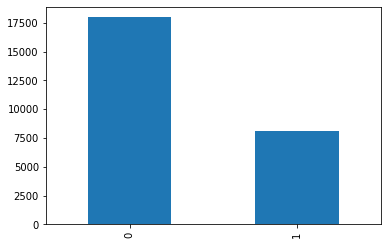

In [14]:
train_data['label'].value_counts().plot(kind = 'bar') #낙상사고 비율 확인

In [15]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  17965
1      1   8080


In [16]:
print(train_data.isnull().values.any()) #null 값이 있는 지 한번 더 확인인

False


In [17]:
print(train_data.isnull().sum()) #2번째 확인인

index             0
HOSPITAL          0
label             0
note              0
anonym            0
translation       0
#ProcessedData    0
#TokenizedData    0
dtype: int64


In [18]:
train_data.loc[train_data.anonym.isnull()] #3번째 확인인

,index,HOSPITAL,label,note,anonym,translation,#ProcessedData,#TokenizedData


In [19]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [20]:
# 한글과 공백을 제외하고 모두 제거
#train_data['anonym'] = train_data['anonym'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
#train_data[:5]

In [21]:
train_data['anonym'] = train_data['anonym'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['anonym'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

index             0
HOSPITAL          0
label             0
note              0
anonym            0
translation       0
#ProcessedData    0
#TokenizedData    0
dtype: int64


<ipython-input-21-310879df2702>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['anonym'] = train_data['anonym'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


3. 토큰화

In [22]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [23]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [24]:
X_train = []
for sentence in tqdm(train_data['anonym']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 26045/26045 [02:29<00:00, 174.44it/s]


In [25]:
#print(X_train[:3])


In [26]:
X_test = []
for sentence in tqdm(test_data['anonym']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 6896/6896 [00:38<00:00, 177.88it/s]


4.인코딩

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #각 단어에 고유한 정수 부여여

In [28]:
#print(tokenizer.word_index)
#가장 많이 나오는 단어들부터 작은 숫자가 매겨짐짐

In [29]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) 
#케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [30]:
print(X_train[:3]) #각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인

[[34, 207, 19, 9, 124, 174, 812, 3132, 220, 80, 1, 9], [82, 488, 890, 606, 44, 3, 146, 195, 48, 3, 1176, 5, 2, 1, 211, 85, 137, 44, 3, 36, 195, 48, 3, 1779, 5, 170, 1, 48, 251, 412, 208, 87, 33, 169, 1, 44, 488, 412, 208, 490, 11, 308, 1, 82, 275, 1, 379, 182, 281, 44, 3, 36, 195, 48, 3, 113, 29, 44, 3, 36, 195, 48, 3, 113, 29, 85, 137, 3, 1325, 5, 170, 1, 82, 127, 442, 208, 10, 1, 143, 178, 201, 20, 4, 24, 26, 2, 1, 482, 1122, 3337, 120, 87, 315, 1, 60, 12, 3459, 400, 1438, 17, 661, 8, 125, 1, 2327, 2021, 11, 1, 17, 661, 8, 125, 1], [1307, 40, 464, 175, 34, 77, 83, 23, 12, 380, 10, 1, 6, 89, 99, 1, 150, 20, 173, 588, 6467, 2175, 14, 4, 47, 43, 21, 69, 56, 10010, 4, 90, 75, 305, 30, 2]]


In [31]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


5. 패딩작업

데이터의 최대 길이 : 472
데이터터의 평균 길이 : 50.538644653484354


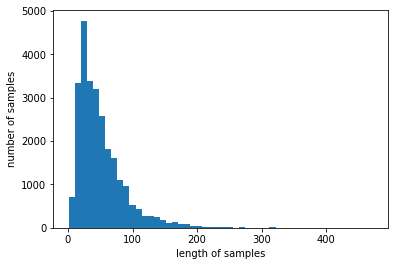

In [32]:
print('데이터의 최대 길이 :',max(len(review) for review in X_train))
print('데이터터의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
#서로다른 길이를 맞추기 위해 패딩작업 진행 120이하로 구성.가장 많은 구성은 약 25정도.

In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [34]:
max_len = 210
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 210 이하인 샘플의 비율: 99.5315799577654


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
vocab_size = len(tokenizer.word_index) + 1

---
**BILSTM을 베이스로 한 모델 구축**

In [37]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding( vocab_size , embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.FalsePositives(name='false_positives'),
                      tf.keras.metrics.FalseNegatives(name='false_negatives'),
                      'accuracy'],
              )
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
81/82 [============================>.] - ETA: 0s - loss: 0.2214 - precision: 0.9287 - recall: 0.7336 - false_positives: 362.0000 - false_negatives: 1713.0000 - accuracy: 0.8999

82/82 [==============================] - 21s 64ms/step - loss: 0.2207 - precision: 0.9291 - recall: 0.7344 - false_positives: 362.0000 - false_negatives: 1716.0000 - accuracy: 0.9003 - val_loss: 0.0972 - val_precision: 0.9528 - val_recall: 0.9716 - val_false_positives: 78.0000 - val_false_negatives: 46.0000 - val_accuracy: 0.9762
Epoch 2/15
81/82 [============================>.] - ETA: 0s - loss: 0.0494 - precision: 0.9764 - recall: 0.9775 - false_positives: 152.0000 - false_negatives: 145.0000 - accuracy: 0.9857

82/82 [==============================] - 4s 46ms/step - loss: 0.0495 - precision: 0.9762 - recall: 0.9774 - false_positives: 154.0000 - false_negatives: 146.0000 - accuracy: 0.9856 - val_loss: 0.0703 - val_precision: 0.9834 - val_recall: 0.9506 - val_false_positives: 26.0000 - val_false_negatives: 80.0000 - val_accuracy: 0.9797
Epoch 3/15
81/82 [============================>.] - ETA: 0s - loss: 0.0790 - precision: 0.9561 - recall: 0.9855 - false_positives: 291.0000 - false_negatives: 93.0000 - accuracy: 0.9815

82/82 [==============================] - 4s 45ms/step - loss: 0.0791 - precision: 0.9563 - recall: 0.9853 - false_positives: 291.0000 - false_negatives: 95.0000 - accuracy: 0.9815 - val_loss: 0.0663 - val_precision: 0.9515 - val_recall: 0.9920 - val_false_positives: 82.0000 - val_false_negatives: 13.0000 - val_accuracy: 0.9818
Epoch 4/15
82/82 [==============================] - ETA: 0s - loss: 0.0321 - precision: 0.9841 - recall: 0.9890 - false_positives: 103.0000 - false_negatives: 71.0000 - accuracy: 0.9916

82/82 [==============================] - 4s 46ms/step - loss: 0.0321 - precision: 0.9841 - recall: 0.9890 - false_positives: 103.0000 - false_negatives: 71.0000 - accuracy: 0.9916 - val_loss: 0.0671 - val_precision: 0.9821 - val_recall: 0.9457 - val_false_positives: 28.0000 - val_false_negatives: 88.0000 - val_accuracy: 0.9777
Epoch 5/15
81/82 [============================>.] - ETA: 0s - loss: 0.0260 - precision: 0.9867 - recall: 0.9908 - false_positives: 86.0000 - false_negatives: 59.0000 - accuracy: 0.9930

82/82 [==============================] - 4s 45ms/step - loss: 0.0259 - precision: 0.9867 - recall: 0.9909 - false_positives: 86.0000 - false_negatives: 59.0000 - accuracy: 0.9930 - val_loss: 0.0421 - val_precision: 0.9772 - val_recall: 0.9796 - val_false_positives: 37.0000 - val_false_negatives: 33.0000 - val_accuracy: 0.9866
Epoch 6/15
82/82 [==============================] - ETA: 0s - loss: 0.0227 - precision: 0.9884 - recall: 0.9910 - false_positives: 75.0000 - false_negatives: 58.0000 - accuracy: 0.9936

82/82 [==============================] - 4s 46ms/step - loss: 0.0227 - precision: 0.9884 - recall: 0.9910 - false_positives: 75.0000 - false_negatives: 58.0000 - accuracy: 0.9936 - val_loss: 0.0754 - val_precision: 0.9206 - val_recall: 0.9944 - val_false_positives: 139.0000 - val_false_negatives: 9.0000 - val_accuracy: 0.9716
Epoch 7/15
81/82 [============================>.] - ETA: 0s - loss: 0.0198 - precision: 0.9879 - recall: 0.9932 - false_positives: 78.0000 - false_negatives: 44.0000 - accuracy: 0.9941

82/82 [==============================] - 4s 46ms/step - loss: 0.0197 - precision: 0.9880 - recall: 0.9932 - false_positives: 78.0000 - false_negatives: 44.0000 - accuracy: 0.9941 - val_loss: 0.0490 - val_precision: 0.9843 - val_recall: 0.9691 - val_false_positives: 25.0000 - val_false_negatives: 50.0000 - val_accuracy: 0.9856
Epoch 8/15
81/82 [============================>.] - ETA: 0s - loss: 0.0181 - precision: 0.9907 - recall: 0.9922 - false_positives: 60.0000 - false_negatives: 50.0000 - accuracy: 0.9947

82/82 [==============================] - 4s 45ms/step - loss: 0.0181 - precision: 0.9907 - recall: 0.9923 - false_positives: 60.0000 - false_negatives: 50.0000 - accuracy: 0.9947 - val_loss: 0.0558 - val_precision: 0.9819 - val_recall: 0.9728 - val_false_positives: 29.0000 - val_false_negatives: 44.0000 - val_accuracy: 0.9860
Epoch 9/15
81/82 [============================>.] - ETA: 0s - loss: 0.0153 - precision: 0.9925 - recall: 0.9944 - false_positives: 48.0000 - false_negatives: 36.0000 - accuracy: 0.9959

82/82 [==============================] - 4s 46ms/step - loss: 0.0152 - precision: 0.9926 - recall: 0.9944 - false_positives: 48.0000 - false_negatives: 36.0000 - accuracy: 0.9960 - val_loss: 0.0528 - val_precision: 0.9778 - val_recall: 0.9809 - val_false_positives: 36.0000 - val_false_negatives: 31.0000 - val_accuracy: 0.9871
Epoch 9: early stopping


In [38]:
model.save("my_model.h5")
#케라스형식 모델 저장 (bestmodel.h5에 자동 저장이 안되기 때문에에)

In [39]:
loaded_model = load_model('my_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

216/216 [==============================] - 4s 14ms/step - loss: 0.0496 - precision: 0.9764 - recall: 0.9837 - false_positives: 48.0000 - false_negatives: 33.0000 - accuracy: 0.9883

 테스트 정확도: 0.9764


In [40]:
def fall_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 낙상사고입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 낙상사고가 아닙니다.\n".format((1 - score) * 100))
#(기본 구성이자 흐름)

In [41]:
fall_predict('와 이거 실화냐? 진짜 가슴이 웅장해진다 내가 생각했던 그 나투로와 사스케가 맞냐? 정말 세계관 최강자들의 싸움이다')

1/1 [==============================] - 2s 2s/step
99.99% 확률로 낙상사고가 아닙니다.



In [42]:
fall_predict('병실에 보호자(아들) 있었으나 수면 중이었으며 올려져 있는 side rail사이의 54cm(발치 쪽)사이로 내려오다가  왼쪽 옆구리를 부딪힌 후 환자  움직이는 소리에 잠에서 깨어난 보호자와 함께 화장실 다녀 왔다함. 낙상 시 side rail에  Lt. flank 부딪혀 통증 있어 X-ray 촬영 후 협진 본 후 진통제 처방 남.')


1/1 [==============================] - 0s 25ms/step
99.93% 확률로 낙상사고입니다.



F1_Score는 0.9800